In [11]:
from IPython.core.display import HTML
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import pysis
import os
import scipy.optimize as sco
import time
import ast
from tkinter import *
from astropy.time import Time
%matplotlib qt
from IPython.core.display import HTML 
from PIL import Image
HTML("<style>.container { width:96% !important; }</style>") 

<h2>Query</h2>  

Longitude is 360-x because of east/west

Small: SELECT * FROM public.vims_trial WHERE latitude<0 AND latitude>-15 AND longitude>110
AND longitude<130 AND incidence>25 AND incidence<30 AND phase>15 AND phase<20 AND emission > 20 AND emission < 25;  
  
Larger: SELECT * FROM public.vims_trial WHERE latitude<0 AND latitude>-15 AND longitude>110
AND longitude<130 AND incidence>25 AND incidence<35 AND phase>15 AND phase<25 AND emission > 20 AND emission < 30;  
  
Largest: SELECT * FROM public.vims_trial WHERE latitude<0 AND latitude>-15 AND longitude>110
AND longitude<130 AND incidence>25 AND incidence<45 AND phase>15 AND phase<35 AND emission > 20 AND emission < 40;

In [12]:
def parse_csv(path_to_csv,channel=69):
    """
    path_to_csv: path to file
    channel: spectra of interest, default is 69.
    
    Returns dictionary containing desired data. Only works for * query.
    """
    data = []
    
    with open(path_to_csv,'r') as f:
        
        head = f.readline().replace('"','').strip().split(',')
        while True:
            try:
                entry = f.readline()
            except:
                break
            if entry == '':
                break
                
            entry=entry.replace('"','').split('{')
            info = entry[0][:-1].split(',')
            
            spectra = list(map(float,entry[1][:-2].split(',')))

            entry_dict = dict()
            for i,col in enumerate(head[:-1]):
                if col not in ['name','sequenceid','observationid','starttime']:
                    entry_dict[col]=float(info[i])
                else:
                    entry_dict[col]=info[i]
            entry_dict['channel']=spectra[channel-1]
            data.append(entry_dict)
    return data
        

In [13]:
parse_csv('dunes_1.csv')

[{'name': 'V1560456861_1.ir_rc20final.cub',
  'sequenceid': 'S31',
  'observationid': 'VIMS_046TI_HIGHRES901_PRIME',
  'latitude': -4.0592310382497,
  'longitude': 128.90000401741,
  'phase': 19.553628675075,
  'incidence': 29.229187870707,
  'emission': 24.83857373681,
  'distance': 41272.345856067,
  'lineres': 73562.603763312,
  'sampres': 19720.669877666,
  'scposx': -35524.334330819,
  'scposy': 20550.661418083,
  'scposz': 4370.1851327259,
  'sunposx': -1244210569.8881,
  'sunposy': 518800092.54163,
  'sunposz': -283802438.22523,
  'ettime': 235035807.8635,
  'starttime': '2007-06-13 19:40:09.398',
  'exposureduration': 80.0,
  'channel': 0.0565425},
 {'name': 'V1560456861_1.ir_rc20final.cub',
  'sequenceid': 'S31',
  'observationid': 'VIMS_046TI_HIGHRES901_PRIME',
  'latitude': -3.6225149688942,
  'longitude': 128.85719397701,
  'phase': 19.525373677334,
  'incidence': 29.401837849358,
  'emission': 24.682808139091,
  'distance': 41272.820360123,
  'lineres': 73360.26875416,
  '

In [62]:
def plot_spectra(data):
    """
    Expects data of the format returned from parse_csv.
    
    Plots spectra vs time.
    """
    
    #When plotting by ettime or Time.jd, the observations are too spaced out, can't see anything. Here just plotted the time strings.
    
    time=[]
    spectra=[]
    phase=[]
    incidence=[]
    emission=[]
    latitude=[]
    longitude=[]
    for entry in data:
        #time.append(entry['ettime'])
        time.append(entry['starttime'])
        spec = entry['channel']*np.cos(entry['incidence']*np.pi/180)/(np.cos(entry['incidence']*np.pi/180)+np.cos(entry['emission']*np.pi/180))
        #spectra.append(entry['channel'])
        spectra.append(spec)
        phase.append(entry['phase'])
        incidence.append(entry['incidence'])
        emission.append(entry['emission'])
        latitude.append(entry['latitude'])
        longitude.append(entry['longitude'])
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.scatter(phase,incidence,emission)
#     ax.set_xlabel('phase')
#     ax.set_ylabel('incidence')
#     ax.set_zlabel('emission')

    #plt.scatter(phase,spectra)
    #plt.scatter(incidence,spectra)
    #plt.scatter(emission,spectra)
    #plt.scatter(Time(time),spectra)
    
    #UNCOMMENT BELOW TO PLOT
#     plt.scatter(time,spectra, c=phase)
#     plt.colorbar()
#     plt.xticks(rotation="45", fontsize='7')
#     plt.xlabel("Time")
#     plt.ylabel("Channel")
#     plt.title("Spectra vs. Time within Bounding Box")
    return time,spectra,phase,incidence,emission,latitude,longitude

In [ ]:
plot_spectra(parse_csv('dunes_larger.csv'))

In [83]:
def create_overlay(query_file):
    """
    query_file: name of csv containing query info.
    
    Returns: 
    """
    time,spectra,phase,incidence,emission,latitude,longitude = plot_spectra(parse_csv(query_file))
    
    dates = {}
    for i,t in enumerate(time):
        d = t[:10]
        if dates.get(d,None) == None:
            dates[d]={'latitude':[latitude[i]],'longitude':[longitude[i]],'spectra':[spectra[i]],'phase':[phase[i]],'incidence':[incidence[i]],'emission':[emission[i]]}
        else:
            dates[d]['latitude'].append(latitude[i])
            dates[d]['longitude'].append(longitude[i])
            dates[d]['spectra'].append(spectra[i])
            dates[d]['phase'].append(phase[i])
            dates[d]['incidence'].append(incidence[i])
            dates[d]['emission'].append(emission[i])
    #return dates
    key = {(0,0): '2007-05-28',(0,1):'2007-05-29',(1,0):'2007-06-13',(1,1):'2007-06-14',(2,0):'2007-06-14',(2,1):'2012-05-22'}
    fig,axes = plt.subplots(3,2)
    for i in range(3):
        for j in range(2):
            axes[i,j].imshow(iss,extent=[0,360,-90,90],cmap='gray')
            axes[i,j].set_xlim(100,140)
            axes[i,j].set_ylim(-20,5)
            axes[i,j].set_title(key[i,j])
            im=axes[i,j].scatter(dates[key[i,j]]['longitude'],dates[key[i,j]]['latitude'],c=dates[key[i,j]]['spectra'])
            plt.colorbar(im,ax=axes[i,j])
            #d.sort()

    #print(order)
#    axes[0,0].scatter(dates[order[0]]['longitude'],dates[order[0]]['latitude'],c=dates[order[0]]['spectra'])
#     axes[0,0].set_xlim(100,150)
#     axes[0,0].set_ylim()
    
    plt.show()
    plt.colorbar()
    return dates

In [84]:
[key for key in create_overlay('dunes_larger.csv')]

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

In [47]:
sorted({3:1,2:5,7:3})

[2, 3, 7]

In [6]:
titan = Image.open('Titan_ISS_P19658_Mosaic_Global_4km.tif')
iss = np.array(titan)

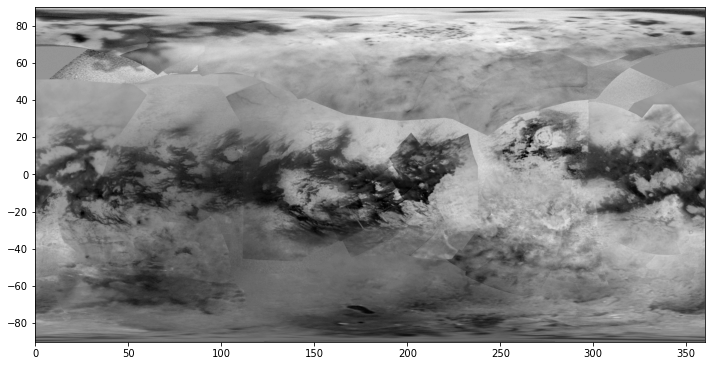

In [9]:
%matplotlib inline
fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(iss,extent=[0,360,-90,90],cmap='gray')

In [23]:
'2007-05-28 23:58:18.06'[:10]

'2007-05-28'

In [26]:
d={1:3}
d.get(2,None)